In [1]:
import numpy as np
from numpy.random import poisson
import pandas as pd
import sklearn
from sklearn.base import clone
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, log_loss
from tensorflow.keras.losses import CategoricalCrossentropy
import mord
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# LINEAR REGRESSION

In statistics, linear regression is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables). The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression. In linear regression, the relationships are modeled using linear predictor functions whose unknown model parameters are estimated from the data.

[Source](https://en.wikipedia.org/wiki/Linear_regression)

### Setting
Given a vector of independent variables, $x = (x_1, x_2, ..., x_n)$, we wan to predict the vector of coefficients, $\beta = (\beta_0, \beta_1, ..., \beta_n)$, such that $\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$ can be used as a predictor for the independent variable, $y$. 

### Estimation - Ordinary Least Squares (OLS) Method
If we extend $x = (x_1, x_2, ..., x_n)$ to $x = (1, x_1, x_2, ..., x_n)$, then we are trying to approximate 
\begin{equation*}y \approx \beta \cdot x\end{equation*} 

In the OLS approach, the optimal parameter vector, $\hat{\beta}$, is given by (where m is the number of samples in the training set)
\begin{equation*} \hat{\beta} = \underset{\beta}{\operatorname{argmin}} \sum_{i=1}^{m} (y_i-\beta \cdot x_i)^2 \end{equation*}

Putting this in matrix format, we get
\begin{equation*} L(D,\beta) = \lvert Y-X\beta \rvert^2 \end{equation*}
\begin{equation*} L(D,\beta) = (Y-X\beta)^T(Y-X\beta) \end{equation*}
\begin{equation*} L(D,\beta) = Y^TY-Y^TX\beta-\beta^TX^TY+\beta^TX^TX\beta\end{equation*}

Since the loss function, $L(D, \beta)$, is convex, the minimum value is reached by equating the gradient to 0.<br><br>
\begin{equation*} \frac{\partial L(D,\beta)}{\partial \beta} = -2Y^TX+2\beta^TX^TX = 0 \end{equation*}
\begin{equation*} \beta = (X^TX)^{-1}X^TY \end{equation*}

### Assumptions
The following are the assumptions made by linear regression models with standard estimation techniques -
1. Weak Exogenity - This essentially means that the model assumes that the predictor variables are error-free, or that they are exact, and not random variables. 
2. Homoscedasticity - This means that the model assumes that the varaince in the error terms is constant, and does not vary across different values of predictor variables. In practice, this assumption rarely ever holds, i.e., error are terms are heteroscedastic. Heteroscedasticity will mean that the different values of the varaince are averaged to get a single variance, which inaccurately represents the variance of the error along the line. Typically, this means that the response variable with higher mean is likely to have a higher variance. Take for example a regression model trying to predict a person's salary. A prediction of 100,000 can have a variance of 20,000, but a prediction of 10,000 is less likelier to have the same varaince. This leads to less precise parameter estimates and incorrect metric scores.
3. Independence of Errors - The error terms are assumed to be independent of each other. Bayesian linear regression is useful for handling correlated errors.
4. Lack of perfect multicollinearity in the predictors - This assumption implies that the design matrix X, must be full rank. In the case of perfect collinearity, the parameter vector, $\beta$ cannot be uniquely predicted.

### Import Dataset
We are going to use the Medical Cost dataset from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).

In [2]:
df = pd.read_csv("./data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.age.min(), df.age.max()

(18, 64)

In [4]:
df["14<Age<25"] = df["age"].apply(lambda x: 1 if 14<x<25 else 0)
df["24<Age<35"] = df["age"].apply(lambda x: 1 if 24<x<35 else 0)
df["34<Age<45"] = df["age"].apply(lambda x: 1 if 34<x<45 else 0)
df["44<Age<55"] = df["age"].apply(lambda x: 1 if 44<x<55 else 0)
df["54<Age<65"] = df["age"].apply(lambda x: 1 if 54<x<65 else 0)
df.drop(columns=["age"], inplace=True)

df["Male"] = df["sex"].apply(lambda x: 1 if x=="male" else 0)
df["Female"] = df["sex"].apply(lambda x: 1 if x=="female" else 0)
df.drop(columns=["sex"], inplace=True)

df["Smoker"] = df["smoker"].apply(lambda x: 1 if x=="yes" else 0)
df["Non-Smoker"] = df["smoker"].apply(lambda x: 1 if x=="no" else 0)
df.drop(columns=["smoker"], inplace=True)

df.drop(columns=["children", "region"], inplace=True)

df.head()

,bmi,charges,14<Age<25,24<Age<35,34<Age<45,44<Age<55,54<Age<65,Male,Female,Smoker,Non-Smoker
0,27.900,16884.92400,1,0,0,0,0,0,1,1,0
1,33.770,1725.55230,1,0,0,0,0,1,0,0,1
2,33.000,4449.46200,0,1,0,0,0,1,0,0,1
3,22.705,21984.47061,0,1,0,0,0,1,0,0,1
4,28.880,3866.85520,0,1,0,0,0,1,0,0,1


The intuition behind making columns for age groups is that the cost of a medical procedure does not depend on the age of a person. However, young and old people have weaker bodies, which can increase the complexity of procedures. Hence, it is assumed that people in different age groups can have different levels of dependence of medical charges on age.

In [5]:
mask = np.random.uniform(0, 1, len(df)) < 0.8
train_df = df[mask]
test_df = df[~mask]

train_df.shape, test_df.shape

((1072, 11), (266, 11))

In [6]:
x_train, y_train = train_df[train_df.columns.difference(["charges"])], train_df.charges
x_train.shape, y_train.shape

((1072, 10), (1072,))

In [7]:
linear_model = sm.OLS(y_train, sm.tools.tools.add_constant(x_train))
result = linear_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     443.8
Date:                Tue, 06 Oct 2020   Prob (F-statistic):          2.23e-310
Time:                        03:22:16   Log-Likelihood:                -10879.
No. Observations:                1072   AIC:                         2.177e+04
Df Residuals:                    1064   BIC:                         2.181e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4957.3065    453.355     10.935      0.0

In [8]:
x_test, y_test = test_df[test_df.columns.difference(["charges"])], test_df.charges
x_test.shape, y_test.shape

((266, 10), (266,))

In [9]:
predictions = result.predict(sm.tools.tools.add_constant(x_test))
predictions

3        2939.603968
7        6762.073990
18      17065.072406
24       6610.401783
25      13347.757663
            ...     
1308    29709.505133
1324     3956.019409
1325    14936.264214
1335     6146.310127
1337    37942.596130
Length: 266, dtype: float64

## Error Metrics

### Mean Absolute Error 
Mean Absolute Error (MAE) is defined as the average difference between the true values (y) and predicted values ($\hat{y}$). It summarizes performance in a way that disregards the direction of over- or under- prediction. It is a negatively oriented score, i.e., lower the value, better is the performance of the model.

### Root Mean Squared Error
Root Mean Squared Error (RMSE) is defined as the square root of the average of squared distance between the true values (y) and predicted values ($\hat{y}$). Like MAE, it summarizes performance in a way that disregards the direction of over- or under- prediction. RMSE is more sensitive to outliers than MAE, i.e., RMSE is more affected by predictions which drastically vary from the true values. RMSE increases with the variance of the frequency distribution of error magnitudes. Again, like MAE, it is a negatively oriented score. RMSE can be a better score for evaluating the model if large errors are particularly undesirable.

### R2 Score
The coefficient of determination, denoted as $R^2$, and pronounced as "R squared", is the fraction of variance in the dependent variable that is explained by the independent variables (regressors). It measures how well the model replicates the observed values, based on the proportion of total variation explained by the model. It is calculated as <br>
\begin{equation*} R^2 = 1-\frac{\sum_{i} (y_i-\hat {y})^2}{\sum_{i} (y_i-\overline {y})^2} \end{equation*}

$R^2$ can vary anywhere in the range $(-\inf, 1]$. Higher the value of $R^2$, higher is the explainability of the model. 

In [10]:
print("\033[1m" + "\033[4m" + "LINEAR REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

LINEAR REGRESSION

Mean Absolute Error = 3934.719
Root Mean Squared Error = 5851.1203
R2 Score = 0.7432


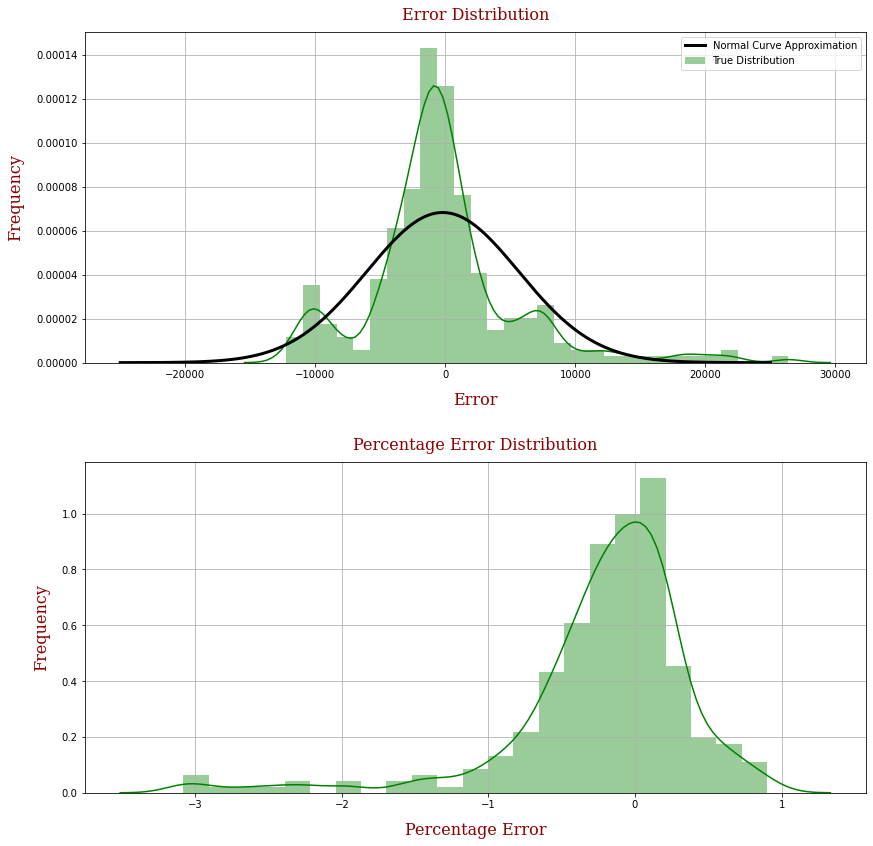

In [11]:
fontdict = {"family":"serif", "color":"darkred", "weight":"normal", "size":16}
x = np.linspace(-25000,25000,100000)
plt.figure(figsize=(14,14))

errors = y_test-predictions
ax = plt.subplot(211)
plot = sns.distplot(errors, color="green", label="True Distribution")
ax.plot(x, stats.norm.pdf(x, np.mean(errors), np.std(errors)), linewidth=3, color="black", label="Normal Curve Approximation")
plot.set_title("Error Distribution", fontdict=fontdict, pad=12)
plot.set_xlabel("Error", fontdict=fontdict, labelpad=12)
plot.set_ylabel("Frequency", fontdict=fontdict, labelpad=12)
ax.grid()
ax.legend()

percentage_error = 1-predictions/y_test
ax = plt.subplot(212)
plot = sns.distplot(percentage_error, color="green")
plot.set_title("Percentage Error Distribution", fontdict=fontdict, pad=12)
plot.set_xlabel("Percentage Error", fontdict=fontdict, labelpad=12)
plot.set_ylabel("Frequency", fontdict=fontdict, labelpad=12)
ax.grid()

plt.subplots_adjust(hspace=0.3)

### Note
In cases where the independent variables suffer from multicolinearity (highly correlated inpdependent variables), even though the least squares estimates are unbiased, they suffer from high variance. This leads to observed value often deviating largely from the true value. The standard errors can be reduced by adding a degree of bias.<br>
In linear regression, the prediction errors, $e = y-\hat{y}$, can be decomposed into two sub components - due to <b>bias</b> in the estimators and due to <b>varaince</b> in them. Assuming the estimators to be unbiased, there are three ways to reduce the varaince in them - Ridge, Lasso and ElasticNet Regularization.

## Ridge Regularization

Ridge regression solves the multicollinearity problem by using a shrinkage parameter, $\lambda$, to add a term to the loss function.

\begin{equation*} L(D,\beta) = \left(Y-\lvert X\beta \rvert^2 \right) + \lambda \lvert \beta \rvert_2^2 \end{equation*}

\begin{equation*} \hat{\beta} = \underset{\beta \in R^p}{\operatorname{argmin}} L(D,\beta) \end{equation*}

The second term is simply $\lambda$ times the squared Frobenius Norm of the coefficient vector.

The assumptions of this regression is same as least squared regression except normality is not to be assumed.

In [12]:
ridge = Ridge(alpha=1.0)
ridge.fit(x_train, y_train)
predictions = ridge.predict(x_test)

print("\033[1m" + "\033[4m" + "RIDGE REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

RIDGE REGRESSION

Mean Absolute Error = 3938.5747
Root Mean Squared Error = 5848.5457
R2 Score = 0.7434


In [13]:
x_train.iloc[:5,:]

,14<Age<25,24<Age<35,34<Age<45,44<Age<55,54<Age<65,Female,Male,Non-Smoker,Smoker,bmi
0,1,0,0,0,0,1,0,0,1,27.90
1,1,0,0,0,0,0,1,1,0,33.77
2,0,1,0,0,0,0,1,1,0,33.00
4,0,1,0,0,0,0,1,1,0,28.88
5,0,1,0,0,0,1,0,1,0,25.74


In [14]:
print(ridge.coef_, "\n")
print(ridge.intercept_)
assert ridge.predict(x_train.iloc[:5,:]).all() == (np.dot(x_train.iloc[:5,:], ridge.coef_) + ridge.intercept_).all()

[ -4370.54300189  -2891.29432755   -900.54969911   2511.23824815
   5651.14878039    118.6664829    -118.6664829  -12049.54818382
  12049.54818383    315.07347984] 

10872.581018635614


## Lasso Regularization

Similar to Ridge Regression, Lasso (Least Absolute Shrinkage and Selection Operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models.

\begin{equation*} L(D,\beta) = \lvert Y-X\beta \rvert^2 + \lambda \lvert \beta \rvert_1 \end{equation*}

\begin{equation*} \hat{\beta} = \underset{\beta \in R^p}{\operatorname{argmin}} L(D,\beta) \end{equation*}

Lasso regression varies from Ridge regression in the sense that it uses the L1 norm of the coefficient vector, instead of the squared Frobenius norm, in the loss function. The loss function is effective in reducing some of the parameter values to 0. Larger the value of $\lambda$, more is the reduction effect. This results to feature selection from given variables. 

The assumptions of this regression is same as least squared regression except normality is not to be assumed.
If group of predictors are highly correlated, lasso picks only one of them and shrinks the others to zero.

In [15]:
lasso = Lasso(alpha=1.0)
lasso.fit(x_train, y_train)
predictions = lasso.predict(x_test)

print("\033[1m" + "\033[4m" + "LASSO REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

LASSO REGRESSION

Mean Absolute Error = 3934.9744
Root Mean Squared Error = 5850.7743
R2 Score = 0.7432


## Elastic Net Regularization

The elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods. Elastic net regularization helps in overcoming the various limitations of lasso regularization -
1. In the "large p, small n" case (high-dimensional data with few examples), the lasso selects at most n variables before it saturates. 
2. If there is a group of highly correlated variables, then the lasso tends to select one variable from a group and ignore the others. To overcome these limitations, the elastic net adds a quadratic part to the penalty (which when used alone is ridge regression).

\begin{equation*} L(D,\beta) = \lvert Y-X\beta \rvert^2 + \lambda_2 \lvert \beta \rvert_2^2 + \lambda_1 \lvert \beta \rvert_1 \end{equation*}

\begin{equation*} \hat{\beta} = \underset{\beta \in R^p}{\operatorname{argmin}} L(D,\beta) \end{equation*}

The quadratic penalty term makes the loss function strongly convex, and it therefore has a unique minimum. 

Elastic-net is useful when there are multiple features which are correlated. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both. It encourages group effect in case of highly correlated variables. However, the naive version of elastic net method finds an estimator in a two-stage procedure: first for each fixed $\lambda_2$ it finds the ridge regression coefficients, and then does a lasso type shrinkage. This kind of estimation incurs a double amount of shrinkage, which leads to increased bias and poor predictions. To improve the predictions performance, the parameters are rescaled by a factor of $(1+\lambda_2)$.

In [16]:
en = ElasticNet(alpha=1.0)
en.fit(x_train, y_train)
predictions = en.predict(x_test)

print("\033[1m" + "\033[4m" + "ELASTIC NET REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

ELASTIC NET REGRESSION

Mean Absolute Error = 6122.9531
Root Mean Squared Error = 8295.994
R2 Score = 0.4838


# POLYNOMIAL REGRESSION

In statistics, polynomial regression is a form of regression analysis in which the relationship test between the independent variable <b>x</b> and the dependent variable <b>y</b> is modelled as an nth degree polynomial in <b>x</b>. 

\begin{equation*} \hat{y} = \beta_0 + (\beta_{11}x_1^1 + \beta_{12}x_1^2 + ... + \beta_{1n}x_1^n) + (\beta_{21}x_2^1 + \beta_{22}x_2^2 + ... + \beta_{2n}x_2^n) + ... + (\beta_{m1}x_m^1 + \beta_{m2}x_m^2 + ... + \beta_{mn}x_m^n) \end{equation*}

\begin{equation*} \hat{y} = \beta_0 + \sum_{i=1}^m \sum_{j=1}^n \beta_{ij} x_i^j \end{equation*}

Polynomial regression fits a nonlinear relationship between the value of <b>x</b> and the corresponding conditional mean of <b>y</b>, denoted $E(y|x)$. Although polynomial regression fits a nonlinear model to the data, <b>as a statistical estimation problem it is linear</b>, in the sense that the regression function $E(y|x)$ is <b>linear in the unknown parameters</b> that are estimated from the data. For this reason, polynomial regression is considered to be a special case of multiple linear regression.

Predicting a nonlinear model in the input features is the same as predicting a linear model in the transformed input features -

\begin{equation*} x' = (x_1^1, x_1^2, ..., x_1^n, x_2^1, x_2^2, ..., x_2^n, ..., x_m^1, x_m^2, ..., x_m^n) \end{equation*}

In [17]:
df = pd.read_csv("./data/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Since quality is a categorical varaible, we will predict the ph value using other variables.

In [18]:
df.drop(["quality"], axis=1, inplace=True)
x_df, y_df = df[df.columns.difference(["pH"])], df[["pH"]]
x_values, y_values = x_df.values, y_df.values
x_df.head()

,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,9.4,0.076,0.00,0.9978,7.4,11.0,1.9,0.56,34.0,0.70
1,9.8,0.098,0.00,0.9968,7.8,25.0,2.6,0.68,67.0,0.88
2,9.8,0.092,0.04,0.9970,7.8,15.0,2.3,0.65,54.0,0.76
3,9.8,0.075,0.56,0.9980,11.2,17.0,1.9,0.58,60.0,0.28
4,9.4,0.076,0.00,0.9978,7.4,11.0,1.9,0.56,34.0,0.70


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2)
x_train.shape, x_test.shape

((1279, 10), (320, 10))

In [20]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)

print("\033[1m" + "\033[4m" + "LINEAR REGRESSION (DEGREE=1)" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions), 4))

LINEAR REGRESSION (DEGREE=1)

Mean Absolute Error = 0.0661
Root Mean Squared Error = 0.0846
R2 Score = 0.6812


In [21]:
polynomial_features_object = PolynomialFeatures(degree=2)
x_train_transform_2 = polynomial_features_object.fit_transform(x_train)
x_test_transform_2 = polynomial_features_object.fit_transform(x_test)

lr_model = LinearRegression()
lr_model.fit(x_train_transform_2, y_train)
predictions_poly_2 = lr_model.predict(x_test_transform_2)

print("\033[1m" + "\033[4m" + "POLYNOMIAL REGRESSION, DEGREE=2" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions_poly_2), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions_poly_2, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions_poly_2), 4))

POLYNOMIAL REGRESSION, DEGREE=2

Mean Absolute Error = 0.0611
Root Mean Squared Error = 0.0765
R2 Score = 0.7388


In [22]:
polynomial_features_object = PolynomialFeatures(degree=3)
x_train_transform_3 = polynomial_features_object.fit_transform(x_train)
x_test_transform_3 = polynomial_features_object.fit_transform(x_test)

lr_model = LinearRegression()
lr_model.fit(x_train_transform_3, y_train)
predictions_poly_3 = lr_model.predict(x_test_transform_3)

print("\033[1m" + "\033[4m" + "POLYNOMIAL REGRESSION, DEGREE=3" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(y_test, predictions_poly_3), 4))
print("Root Mean Squared Error =", round(mean_squared_error(y_test, predictions_poly_3, squared=False), 4))
print("R2 Score =", round(r2_score(y_test, predictions_poly_3), 4))

POLYNOMIAL REGRESSION, DEGREE=3

Mean Absolute Error = 0.0657
Root Mean Squared Error = 0.092
R2 Score = 0.6227


# LOGISTIC REGRESSION

Logistic regression (or logit) is a statistical model used for a binary classification task - pass/fail, 0/1, etc. The model uses regression techniques to predict the probability of the two class labels for the dependent variables, such that the probabilities sum to 1. Often, a composition of the sigmoid function and a linear combination of the independent variables is used to predict the class probabilities.

<b>Where does the sigmoid function come from?</b><br>
The model assumes a linear relation between the independent variables and the log odds of the event that $Y=1$. That is, if $p$ is the probability, P(Y=1), then

\begin{equation*} \log_b\left(\frac{p}{1-p}\right) = \beta X \end{equation*}

In most cases, the value of the base of the algorithm, $b$, is taken to be $e$. However, in some scenarios, a differet choice of the base, like 2 or 10, can help better communicate results. <br>The above equation gives
\begin{equation*} p = \frac{1}{1+b^{-\beta X}} \end{equation*}

Which, for $b=e$ is the sigmoid function.

Since the sigmoid function is continuous between 0 and 1, but our response varaible is a categorical variable, we need to set a threshhold cut-off, like 0.5. All outputs from the sigmoid which have value above threshhold are classified as 1, while others, 0.

In [23]:
df = pd.read_csv("./data/candy-data.csv", index_col=0)
df.head()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
competitorname,,,,,,,,,,,,
100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


<b>Dataset Columns</b><br><br>
chocolate: Does it contain chocolate?<br>
fruity: Is it fruit flavored?<br>
caramel: Is there caramel in the candy?<br>
peanutalmondy: Does it contain peanuts, peanut butter or almonds?<br>
nougat: Does it contain nougat?<br>
crispedricewafer: Does it contain crisped rice, wafers, or a cookie component?<br>
hard: Is it a hard candy?<br>
bar: Is it a candy bar?<br>
pluribus: Is it one of many candies in a bag or box?<br>
sugarpercent: The percentile of sugar it falls under within the data set.<br>
pricepercent: The unit price percentile compared to the rest of the set.<br>
winpercent: The overall win percentage according to 269,000 matchups.

<b>We'll try and answer the question of whether an ingredient is present in a candy, given its Sugar Percentage and Win Percentage.</b>

In [24]:
df.drop(["pricepercent"], axis=1, inplace=True)
mapper = {"chocolate":"Chocolate", "fruity":"Fruity", "caramel":"Caramel", "peanutyalmondy":"Peanut Almondy", "nougat":"Nougat",\
         "crispedricewafer":"Crisped Rice Wafer", "hard":"Hard", "bar":"Bar", "pluribus":"Pluribus", "sugarpercent":"Sugar Percent",\
         "winpercent":"Win Percent"}
df.rename(columns=mapper, inplace=True)
df.head()

,Chocolate,Fruity,Caramel,Peanut Almondy,Nougat,Crisped Rice Wafer,Hard,Bar,Pluribus,Sugar Percent,Win Percent
competitorname,,,,,,,,,,,
100 Grand,1,0,1,0,0,1,0,1,0,0.732,66.971725
3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,67.602936
One dime,0,0,0,0,0,0,0,0,0,0.011,32.261086
One quarter,0,0,0,0,0,0,0,0,0,0.011,46.116505
Air Heads,0,1,0,0,0,0,0,0,0,0.906,52.341465


In [25]:
mask = np.random.uniform(0, 1, len(df)) < 0.8
train_df = df[mask]
test_df = df[~mask]
df.shape, train_df.shape, test_df.shape

((85, 11), (66, 11), (19, 11))

In [26]:
for column in df.columns.difference(["Sugar Percent", "Win Percent"]):
    
    model = LogisticRegression()
    model.fit(train_df[["Sugar Percent", "Win Percent"]].values, train_df[column].values)
    test_x, test_y = test_df[["Sugar Percent", "Win Percent"]].values, test_df[column].values
    probability_predictions = model.predict_proba(test_x)
    
    print("\033[1m" + "\033[4m" + column + "\033[0m" + "\n")
    print("Mean Accuracy Score =", round(model.score(test_x, test_y), 4))
    print("Cross-Entropy Loss =", round(log_loss(test_y, probability_predictions, labels=[0,1]), 4), end="\n\n")
    print(classification_report(test_y, np.argmax(probability_predictions, axis=1)))

Bar

Mean Accuracy Score = 0.8947
Cross-Entropy Loss = 0.2835

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.50      0.50      0.50         2

    accuracy                           0.89        19
   macro avg       0.72      0.72      0.72        19
weighted avg       0.89      0.89      0.89        19

Caramel

Mean Accuracy Score = 0.8421
Cross-Entropy Loss = 0.3758

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.00      0.00      0.00         3

    accuracy                           0.84        19
   macro avg       0.42      0.50      0.46        19
weighted avg       0.71      0.84      0.77        19

Chocolate

Mean Accuracy Score = 0.8947
Cross-Entropy Loss = 0.3178

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.75     

# ORDINAL REGRESSION

In statistics, ordinal regression (also called "ordinal classification") is a type of regression analysis used for predicting an ordinal variable, i.e., a variable whose value exists on an arbitrary scale where only the relative ordering between different values is significant. It can be considered an intermediate problem between regression and classification.

One of the assumptions underlying ordinal logistic (and ordinal probit) regression is that the relationship between each pair of outcome groups is the same. In other words, ordinal logistic regression assumes that the coefficients that describe the relationship between, say, the lowest versus all higher categories of the response variable are the same as those that describe the relationship between the next lowest category and all higher categories, etc. This is called the proportional odds assumption or the parallel regression assumption. Because the relationship between all pairs of groups is the same, there is only one set of coefficients.

[Source](https://stats.idre.ucla.edu/r/dae/ordinal-logistic-regression/)

## Ordinal Rgression with Custom Class

This Python class performs ordinal regression using multiple logistic regression (classifier) models. 

The labels are first sorted. Assume we have 4 labels, and they are in the order $c_1$, $c_2$, $c_3$, $c_4$. 

Now, we convert the problem into a binary classification problem. For each class, $c_i$, except the last one, we calculate the probability, $P(i)$, that it belongs to one of the classes $c_j$, $j>i$, i.e., $P(i) = P(c=c_j | j>i). 

$P(c=c_1) = 1-P(1)$ <br> $P(c=c_2) = P(1)-P(2)$ <br> $P(c=c_3) = P(2)-P(3)$ <br> $P(c=c_4) = P(3)$ 

Now, all that's left is to find the class with the maximum probability. 

Checkout [this article](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c) for a more detailed explaination.

### Load Dataset 
We use the iris dataset from sklearn, and split the dataset, keeping 20% of the entries for validation.

In [27]:
X, y = load_iris(return_X_y=True)
print("X[:5] =", X[:5], sep="\n")
print("\ny[:5] =", y[:5])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=True)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

X[:5] =
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]

y[:5] = [0 0 0 0 0]


((120, 4), (30, 4), (120,), (30,))

In [28]:
class ordinal_classifier():
    
    
    def __init__(self, classifier):
        
        self.classifier = classifier
        self.classifiers = {}                                          # class_label_idx : class_label_classifier
        
    def fit(self, X, y):
        
        self.unique_classes = np.sort(np.unique(y))
        self.num_unique_classes = self.unique_classes.shape[0]
        
        for class_label_idx, class_label in enumerate(self.unique_classes[:-1]):
            class_label_binary_y = (y>class_label).astype(int)
            class_label_classifier = clone(self.classifier)
            class_label_classifier.fit(X, class_label_binary_y)
            self.classifiers[class_label_idx] = class_label_classifier
            
    def predict_probabilities(self, X):
        
        classifiers_predictions = {idx:classifier.predict_proba(X) for (idx, classifier) in self.classifiers.items()}
        
        probability_prediction_class_label_0 = classifiers_predictions[0][:,1]
        probability_predictions = [1-probability_prediction_class_label_0]
        
        for idx, class_label in enumerate(self.unique_classes):
            if idx!=0 and idx!=self.num_unique_classes-1:
                probability_prediction = classifiers_predictions[idx-1][:,1] - classifiers_predictions[idx][:,1]
                probability_predictions.append(probability_prediction)
        
        probability_prediction_class_label_last = classifiers_predictions[self.unique_classes.shape[0]-2][:,1]
        probability_predictions.append(probability_prediction_class_label_last)
        
        return np.array(probability_predictions).T
    
    def predict(self, X):
        
        return np.argmax(self.predict_probabilities(X), axis=1)

In [29]:
oc_object = ordinal_classifier(LogisticRegression())
oc_object.fit(train_X, train_y)

probability_predictions = oc_object.predict_probabilities(test_X)
class_predictions = oc_object.predict(test_X)
print(classification_report(test_y, class_predictions, digits=3))

enc_object = OneHotEncoder()
one_hot_test_y = enc_object.fit_transform(test_y.reshape(-1,1)).toarray()

cce = CategoricalCrossentropy()
print("Categorical Cross-entropy Loss =", round(cce(one_hot_test_y, probability_predictions).numpy(), 4))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.750     1.000     0.857         9
           2      1.000     0.769     0.870        13

    accuracy                          0.900        30
   macro avg      0.917     0.923     0.909        30
weighted avg      0.925     0.900     0.901        30

Categorical Cross-entropy Loss = 0.1747


# POISSON REGRESSION

Poisson regression is a form of regression analysis used to model count data (data in which the observations can only take non-negative integer values, and where these integers arise from counting) and contingency tables (used to store multivariate frequency dustributions of varaibles).

The response variable is expected to follow a poisson distribution, with parameter $\lambda$, which is the expected value. Hence, one can expect to observe $\lambda$ events in a unit time frame. In t units of time, one expect to observe $\lambda$t events.

## Regression Model with Constant $\lambda$

In situations where the data seems to follow a poisson distribution with constant $\lambda$, it is easy to predict the future counts of events using a Mean Model - a model which predicts a constant value which is the mean of the data. Such situations can be observed in various areas like number of people visiting a shop every hour, number of people in line in front of you at the checkout counter of a store, etc.

To illustrate, we generate a random sample of size 20 from a poisson distribution with $\lambda = 5$.

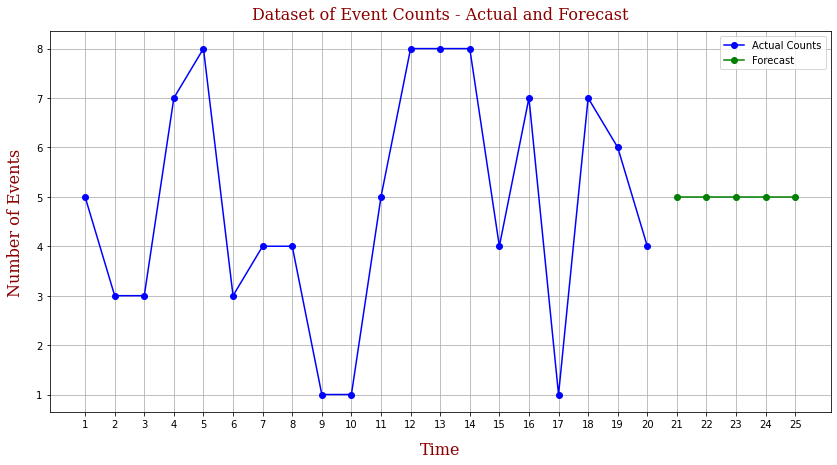

In [30]:
X_y = list(range(1,21))
y = poisson(lam=5., size=20)

X_forecast = list(range(21,26))
forecast = [5]*5

fontdict = {"family":"serif", "color":"darkred", "weight":"normal", "size":16}

plt.figure(figsize=(14,7))
plt.title("Dataset of Event Counts - Actual and Forecast", fontdict=fontdict, pad=12)
plt.plot(X_y, y, "bo-", label="Actual Counts")
plt.plot(X_forecast, forecast, "go-", label="Forecast")
plt.xlabel("Time", fontdict=fontdict, labelpad=12)
plt.ylabel("Number of Events", fontdict=fontdict, labelpad=12)
plt.xticks(ticks=list(X_y+X_forecast))
plt.legend()
plt.grid()

## Regression Model with Non-Constant $\lambda$

Suppose we have n independent variables (regression variables), m data entries, and we are trying to predict the independent variable y which, for a given <b>x</b>, follows a poisson distribution. The probability mass function of $y$ over $x_i$ is given as ($\beta$ is the vector of regression coefficients) <br><br>
\begin{equation*} P(y|x_i) = \frac{e^{-\lambda_i}{\lambda_i}^{y}}{y!} \end{equation*} 

$\eta = x_i\beta$ is called the <b>Linear Estimator</b>. We also define a <b>Link Function</b>, $g$, such that $E(y_i|x_i) = \mu = g^{-1}(\eta)$. <br>The link function provides the relationship between the linear predictor and the mean of the distribution function. There are many commonly used link functions, and their choice is informed by several considerations. <br>For Poisson Regression, the link function is chosen to be $g(n) = \ln(n)$. This gives <br><br>
\begin{equation*} \lambda_i = e^{x_i\beta} \end{equation*}

Once the model is trained on the dataset and the regression coefficents $\beta$ are known, we predict $\hat{y}_i = \lambda_i = e^{x_i\beta}$. The vector $\beta$ is calculated using the <b>Maximum Likelihood Estimation (MLE)</b>. 

The probability of predicting $y_i$ for each data entry is <br>
\begin{equation*} P(y_i|x_i) = \frac{e^{-\lambda_i}{\lambda_i}^{y_i}}{y_i!} \end{equation*}

The joint probability distribution for predicting $y$, the set of response variables, and $X$, the set of input feature vectors, is given as <br><br>
\begin{equation*} L(\beta) = P(y|X) = \prod_{i=1}^{m} P(y_i|x_i) = \prod_{i=1}^{m} \frac{e^{-\lambda_i}{\lambda_i}^{y_i}}{y_i!} \end{equation*}
\begin{equation*} \ln L(\beta) = \sum_{i=1}^{m} (y_i x_i \beta - e^{x_i \beta} - \ln(y!)) \end{equation*}

This logarithmic equation is called <b> Log-Likelihood Function </b>. To minimize the function with respect to $\beta$, we differentiate and equate the derivative to 0, giving <br><br>
\begin{equation*} \sum_{i=1}^{m} x_i(y_i - e^{x_i \beta}) = 0 \end{equation*}

The Maximum Likelihood Estimate for $\beta$ is given by solving this equation. One can use iterative methods, like Iteratively Reweighted Least Squares ([IRLS](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares)), to solve this equation.

### We'll perform Poisson Regression on a dataset of Bicyclists Count on the Brooklyn Bridge
Dataset available [here](https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe#file-nyc_bb_bicyclist_counts-csv).

In [31]:
df = pd.read_csv("./data/nyc_bb_bicyclist_counts.csv", index_col=0)
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
1-Apr-17,46.0,37.0,0.00,606
2-Apr-17,62.1,41.0,0.00,2021
3-Apr-17,63.0,50.0,0.03,2470
4-Apr-17,51.1,46.0,1.18,723
5-Apr-17,63.0,46.0,0.00,2807


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 1-Apr-17 to 31-Oct-17
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HIGH_T    214 non-null    float64
 1   LOW_T     214 non-null    float64
 2   PRECIP    214 non-null    float64
 3   BB_COUNT  214 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 8.4+ KB


There's no need to clean any data. We can move on to rgeression analysis. Let's just add columns for the days of the week before that. 

In [33]:
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for day in days_of_the_week:
    df[day] = df.index.to_series().apply(lambda x: 1 if datetime.strptime(x, "%d-%b-%y").strftime("%A")==day else 0)
df["Intercept"] = 1
df = df[["HIGH_T", "LOW_T", "PRECIP"]+days_of_the_week+["BB_COUNT"]]
df.head()

,HIGH_T,LOW_T,PRECIP,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,BB_COUNT
Date,,,,,,,,,,,
1-Apr-17,46.0,37.0,0.00,0,0,0,0,0,1,0,606
2-Apr-17,62.1,41.0,0.00,0,0,0,0,0,0,1,2021
3-Apr-17,63.0,50.0,0.03,1,0,0,0,0,0,0,2470
4-Apr-17,51.1,46.0,1.18,0,1,0,0,0,0,0,723
5-Apr-17,63.0,46.0,0.00,0,0,1,0,0,0,0,2807


In [34]:
x_values = df[df.columns.difference(["BB_COUNT"])]
y_values = df[["BB_COUNT"]]
print("X shape = {}; y shape = {}".format(x_values.shape, y_values.shape))

X shape = (214, 10); y shape = (214, 1)


In [35]:
train_X, test_X, train_y, test_y = train_test_split(x_values, y_values, test_size=0.15, shuffle=True)
print("Number of entries for training = {}; Number of entries for validation = {}".format(train_X.shape[0], test_X.shape[0]))

Number of entries for training = 181; Number of entries for validation = 33


In [36]:
poisson_model = sm.GLM(train_y, train_X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  181
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13493.
Date:                Tue, 06 Oct 2020   Deviance:                       25241.
Time:                        03:22:22   Pearson chi2:                 2.50e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Friday         7.0611      0.012    591.257      0.0

Column 1 gives the coefficients of regression for each of the varaibles. Last two columns give the 95% confidence interval for the coefficients.

Let's now predict on test_X.

In [37]:
predictions = poisson_results.get_prediction(test_X)
predictions_summary = predictions.summary_frame()
predictions_summary.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
20-Apr-17,2561.196626,11.970533,2537.841945,2584.766230
12-Oct-17,2400.385041,10.407785,2380.072588,2420.870848
22-May-17,1492.779106,7.918685,1477.339172,1508.380406
7-Jun-17,2748.443313,11.778176,2725.455190,2771.625333
5-Sep-17,3323.838915,12.886517,3298.677525,3349.192230


In [38]:
print("\033[1m" + "\033[4m" + "POISSON REGRESSION" + "\033[0m" + "\n")
print("Mean Absolute Error =", round(mean_absolute_error(test_y, predictions_summary["mean"].values), 4))
print("Root Mean Squared Error =", round(mean_squared_error(test_y, predictions_summary["mean"].values, squared=False), 4))
print("R2 Score =", round(r2_score(test_y, predictions_summary["mean"].values), 4))

POISSON REGRESSION

Mean Absolute Error = 365.4989
Root Mean Squared Error = 448.0736
R2 Score = 0.5806


To compare the results with linear regression, we will form a linear regression model and calculate the metrics.

In [39]:
model = LinearRegression()
model.fit(train_X, train_y)
lr_predictions = model.predict(test_X)

In [40]:
print("\033[1m" + "\033[4m" + "LINEAR REGRESSION" + "\033[0m")
print("Mean Absolute Error =", round(mean_absolute_error(test_y, lr_predictions), 4))
print("Root Mean Squared Error =", round(mean_squared_error(test_y, lr_predictions, squared=False), 4))
print("R2 Score =", round(r2_score(test_y, lr_predictions), 4))

LINEAR REGRESSION
Mean Absolute Error = 374.1826
Root Mean Squared Error = 475.8052
R2 Score = 0.5271


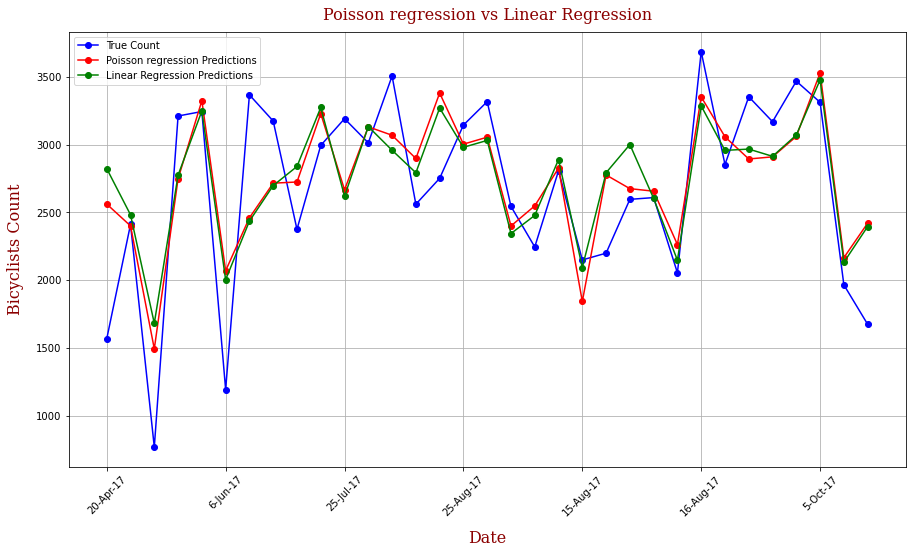

In [41]:
fontdict = {"family":"serif", "color":"darkred", "weight":"normal", "size":16}

plt.figure(figsize=(15,8))
plt.title("Poisson regression vs Linear Regression", fontdict=fontdict, pad=12)
plt.plot(test_y.index, test_y.BB_COUNT, "bo-", label="True Count")
plt.plot(test_y.index, predictions_summary["mean"].values, "ro-", label="Poisson regression Predictions")
plt.plot(test_y.index, lr_predictions, "go-", label="Linear Regression Predictions")
plt.xlabel("Date", fontdict=fontdict, labelpad=12)
plt.ylabel("Bicyclists Count", fontdict=fontdict, labelpad=12)
xticks = plt.xticks()
plt.xticks(list(xticks)[0][::5], rotation=45)
plt.legend()
plt.grid()